# TITANIC - Problema de Clasificación

Este problema nos proporciona distinta información de los pasajeros del famoso Titanic, trágico suceso donde el transátlanticos se hundió tras el choque con un iceberg. Causó la muerte de 1502 personas de las 2224 compuestas por pasajeros y tripulación. 
La información disponible de cada persona es:

- ID pasajero: Identificador del pasajero
- Pclass: Tipo de billete (1: primera, 2: segunda, 3: tercera clase)
- Name: Nombre completo del pasajero
- Sex: Género del pasajero
- Age: Edad
- SibSp: Número de hermanos o pareja a bordo
- Parch: Número de padres o hijos a bordo
- Ticket: Número de ticket
- Fare: Tarifa
- Cabin: Número de cabina
- Embarked: Puerta de embarque (C: Cherbourg, Q: Queenstown, S: Southampton)
- Survived: Si ha sobrevivido o no (1: Si, 0: No)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#Carga de datos
train = pd.read_csv("./Titanic/train.csv")
test = pd.read_csv("./Titanic/test.csv")
solucion = pd.read_csv("./Titanic/gender_submission.csv")

In [2]:
print(train.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [3]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#Conversion de columnas categoricas a binarias

train["male"]= [1 if i=="male" else 0 for i in train["Sex"]]
train.head(5)
test["male"]= [1 if i=="male" else 0 for i in test["Sex"]]
test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,male
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


# Limpieza de datos


In [5]:
print("En el conjunto de entrenamiento se tienen:\n")
for col in train.columns.tolist():
    print(col, "tiene", train[col].isnull().sum(), "valores nulos\n")

print("\n")
print("En el conjunto de test se tienen ", len(test)," personas de los cuales son:\n")
for col in test.columns.tolist():
    print(col, "tiene", test[col].isnull().sum(), "valores nulos\n")

En el conjunto de entrenamiento se tienen:

PassengerId tiene 0 valores nulos

Survived tiene 0 valores nulos

Pclass tiene 0 valores nulos

Name tiene 0 valores nulos

Sex tiene 0 valores nulos

Age tiene 177 valores nulos

SibSp tiene 0 valores nulos

Parch tiene 0 valores nulos

Ticket tiene 0 valores nulos

Fare tiene 0 valores nulos

Cabin tiene 687 valores nulos

Embarked tiene 2 valores nulos

male tiene 0 valores nulos



En el conjunto de test se tienen  418  personas de los cuales son:

PassengerId tiene 0 valores nulos

Pclass tiene 0 valores nulos

Name tiene 0 valores nulos

Sex tiene 0 valores nulos

Age tiene 86 valores nulos

SibSp tiene 0 valores nulos

Parch tiene 0 valores nulos

Ticket tiene 0 valores nulos

Fare tiene 1 valores nulos

Cabin tiene 327 valores nulos

Embarked tiene 0 valores nulos

male tiene 0 valores nulos



Las columnas de la edad, el número de cabina, la tarifa y donde embarcaron tienen valores nulos.

En el caso de la edad los valores nulos representan un 19.8% del total en training (similar en test), siendo necesario darles algún valor al no ser una cantidad pequeña de casos para poder eliminarlos, ni acercarse al total de casos para no tenerla en cuenta.

El número de cabina tiene un 77.1% de valores nulos en training (similar en test), es una cantidad alta de datos nulos donde podriamos intentar resolver el problema sin tenerlo en cuenta, pero que es una variable importante debido a que especifica la localización de la cabina en el barco y puede ser un factor importante en la supervivencia de los pasajeros.

La tarifa en el conjunto de test tiene un valor nulo, analizaremos la información de esa persona para asignar un valor con sentido. 

Y finalmente dos personas con embarcacion desconocida en el conjunto de training, que se intentará seguir el mismo procedimiento que con la tarifa.

In [6]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,0.042939
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,-0.543351
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,0.131900
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.093254
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.114631
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,-0.245489
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,-0.182333
male,0.042939,-0.543351,0.131900,0.093254,-0.114631,-0.245489,-0.182333,1.000000


In [7]:
test.corr()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male
PassengerId,1.000000,-0.026751,-0.034102,0.003818,0.043080,0.008211,0.023245
Pclass,-0.026751,1.000000,-0.492143,0.001087,0.018721,-0.577147,0.108615
Age,-0.034102,-0.492143,1.000000,-0.091587,-0.061249,0.337932,0.000013
SibSp,0.003818,0.001087,-0.091587,1.000000,0.306895,0.171539,-0.099943
Parch,0.043080,0.018721,-0.061249,0.306895,1.000000,0.230046,-0.159120
Fare,0.008211,-0.577147,0.337932,0.171539,0.230046,1.000000,-0.191514
male,0.023245,0.108615,0.000013,-0.099943,-0.159120,-0.191514,1.000000


In [8]:
todos = pd.concat([train,test],sort=True).reset_index(drop=True)

- Edad 


In [9]:
todos["Titulo"]= todos["Name"].str.split(",",expand=True)[1].str.split(".",expand=True)[0]

todos["Titulo"] = todos["Titulo"].replace(['Dona','Lady','the Countess','Ms'],'Mrs',regex=True)
todos["Titulo"] = todos["Titulo"].replace(['Mme','Mlle'],'Miss',regex=True)
todos["Titulo"].value_counts()

#Dr tiene 1 null(male 1 clase), 8 master con null, 28 Mrs con null, 50 Miss con null , 204 - 28 Mr con null

 Mr          757
 Miss        263
 Mrs         202
 Master       61
 Rev           8
 Dr            8
 Col           4
 Major         2
 Don           1
 Sir           1
 Capt          1
 Jonkheer      1
Name: Titulo, dtype: int64

In [10]:
edad_por_clase_genero = todos.groupby(["Sex","Pclass","Titulo"]).median()["Age"]
edad_por_clase_genero

Sex     Pclass  Titulo   
female  1        Dr          49.0
                 Miss        30.0
                 Mrs         45.0
        2        Miss        20.0
                 Mrs         30.0
        3        Miss        18.0
                 Mrs         31.0
male    1        Capt        70.0
                 Col         54.5
                 Don         40.0
                 Dr          47.0
                 Jonkheer    38.0
                 Major       48.5
                 Master       6.0
                 Mr          41.5
                 Sir         49.0
        2        Dr          38.5
                 Master       2.0
                 Mr          30.0
                 Rev         41.5
        3        Master       6.0
                 Mr          26.0
Name: Age, dtype: float64

In [11]:
todos["Age"]=todos.groupby(["Sex","Pclass","Titulo"])["Age"].apply(lambda x: x.fillna(x.median()))

La columna edad tiene correlacion con la clase en la que viaja la persona (un 0.37 en training y un 0.49 en test), combinando con el género para diferenciar más los distintos casos existentes. Además el nombre contiene un titulo que nos puede ayudar más aún para especificar la edad de aquellas personas en la que no este registrada.

- Tarifa

In [12]:
tarifa_po = todos.groupby(["SibSp","Pclass","Parch"]).median()["Fare"]
tarifa_po

SibSp  Pclass  Parch
0      1       0         31.33960
               1         63.35830
               2         83.15830
       2       0         13.00000
               1         23.00000
               2         26.25000
               3         39.00000
       3       0          7.85420
               1         12.47500
               2         15.24580
               3         19.25830
               4         23.27085
               5         34.40625
1      1       0         75.25000
               1         83.15830
               2        120.00000
               3        262.37500
               4        263.00000
       2       0         26.00000
               1         26.25000
               2         41.57920
               3         23.00000
       3       0         14.45625
               1         15.24580
               2         22.01250
               3         34.37500
               4         27.90000
               5         31.33125
               6         46

In [13]:
# Pertenece a un hombre de clase 3 con 0 hijos y 0 hermanos/pareja
todos["Fare"] = todos["Fare"].fillna(7.8542)

- Embarque

In [14]:
embarked_po = todos.groupby(["Pclass","Embarked","male"]).median()["Fare"]
embarked_po

Pclass  Embarked  male
1       C         0       83.15830
                  1       62.66875
        Q         0       90.00000
                  1       90.00000
        S         0       78.85000
                  1       35.50000
2       C         0       27.72080
                  1       15.04580
        Q         0       12.35000
                  1       12.35000
        S         0       23.00000
                  1       13.00000
3       C         0       14.45420
                  1        7.22920
        Q         0        7.75000
                  1        7.75000
        S         0       13.77500
                  1        8.05000
Name: Fare, dtype: float64

In [15]:
todos[todos["Embarked"].isnull()]
# Dos mujeres supervivientes de 1ª clase con una tarifa de 80, Southampton es donde más instancias hay
todos["Embarked"] = todos["Embarked"].fillna('S')

todos["Emb_C"]= [1 if i=="C" else 0 for i in todos["Embarked"]]
todos["Emb_S"]= [1 if i=="S" else 0 for i in todos["Embarked"]]
todos["Emb_Q"]= [1 if i=="Q" else 0 for i in todos["Embarked"]]
todos.head(5)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,male,Titulo,Emb_C,Emb_S,Emb_Q
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,1,Mr,0,1,0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,0,Mrs,1,0,0
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,0,Miss,0,1,0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,0,Mrs,0,1,0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,Mr,0,1,0


- Número de Cabina

Optamos por no tenerlo en cuenta ante la gran cantidad de datos null

# Tratamiento de datos

In [16]:
train = todos.loc[:890]
test = todos.loc[891:]

In [17]:
surv = train.loc[train["Survived"]==1]
porc_surv = len(surv)/len(train)
print("El porcentaje de supervivientes es de", porc_surv*100, "del total, con",len(surv)," supervivientes.")

El porcentaje de supervivientes es de 38.38383838383838 del total, con 342  supervivientes.


- Genero

In [18]:
surv_hombre = surv.loc[surv["Sex"]=="male"]
train_hombre = train.loc[train["Sex"]=="male"]

porc_hombres = len(surv_hombre)/len(train_hombre)
print("El porcentaje de hombres supervivientes es ", porc_hombres*100, ", ", len(surv_hombre),"supervivientes de ",len(train_hombre)," hombres.")

El porcentaje de hombres supervivientes es  18.890814558058924 ,  109 supervivientes de  577  hombres.


In [19]:
surv_mujer = surv.loc[surv["Sex"]=="female"]
train_mujer = train.loc[train["Sex"]=="female"]

porc_mujeres = len(surv_mujer)/len(train_mujer)
print("El porcentaje de mujeres supervivientes es ", porc_mujeres*100 ,", ", len(surv_mujer),"supervivientes de ",len(train_mujer)," mujeres.")

El porcentaje de mujeres supervivientes es  74.20382165605095 ,  233 supervivientes de  314  mujeres.


- Clase

In [20]:
surv_primera = surv.loc[surv["Pclass"]==1]

surv_segunda = surv.loc[surv["Pclass"]==2]

surv_tercera = surv.loc[surv["Pclass"]==3]

porc_primera = len(surv_primera)/len(train.loc[train["Pclass"]==1])
print("El porcentaje de personas supervivientes de primera clase es ", porc_primera*100,", ", len(surv_primera),
      "supervivientes de ",len(train.loc[train["Pclass"]==1])," pasajeros de primera clase.")

porc_segunda = len(surv_segunda)/len(train.loc[train["Pclass"]==2])
print("El porcentaje de personas supervivientes de segunda clase es ", porc_segunda*100,", ", len(surv_segunda),
      "supervivientes de ",len(train.loc[train["Pclass"]==2])," pasajeros de segunda clase.")

porc_tercera = len(surv_tercera)/len(train.loc[train["Pclass"]==3])
print("El porcentaje de personas supervivientes de tercera clase es ", porc_tercera*100,", ", len(surv_tercera),
      "supervivientes de ",len(train.loc[train["Pclass"]==3])," pasajeros de tercera clase.")

El porcentaje de personas supervivientes de primera clase es  62.96296296296296 ,  136 supervivientes de  216  pasajeros de primera clase.
El porcentaje de personas supervivientes de segunda clase es  47.28260869565217 ,  87 supervivientes de  184  pasajeros de segunda clase.
El porcentaje de personas supervivientes de tercera clase es  24.236252545824847 ,  119 supervivientes de  491  pasajeros de tercera clase.


- Edad y Tarifa

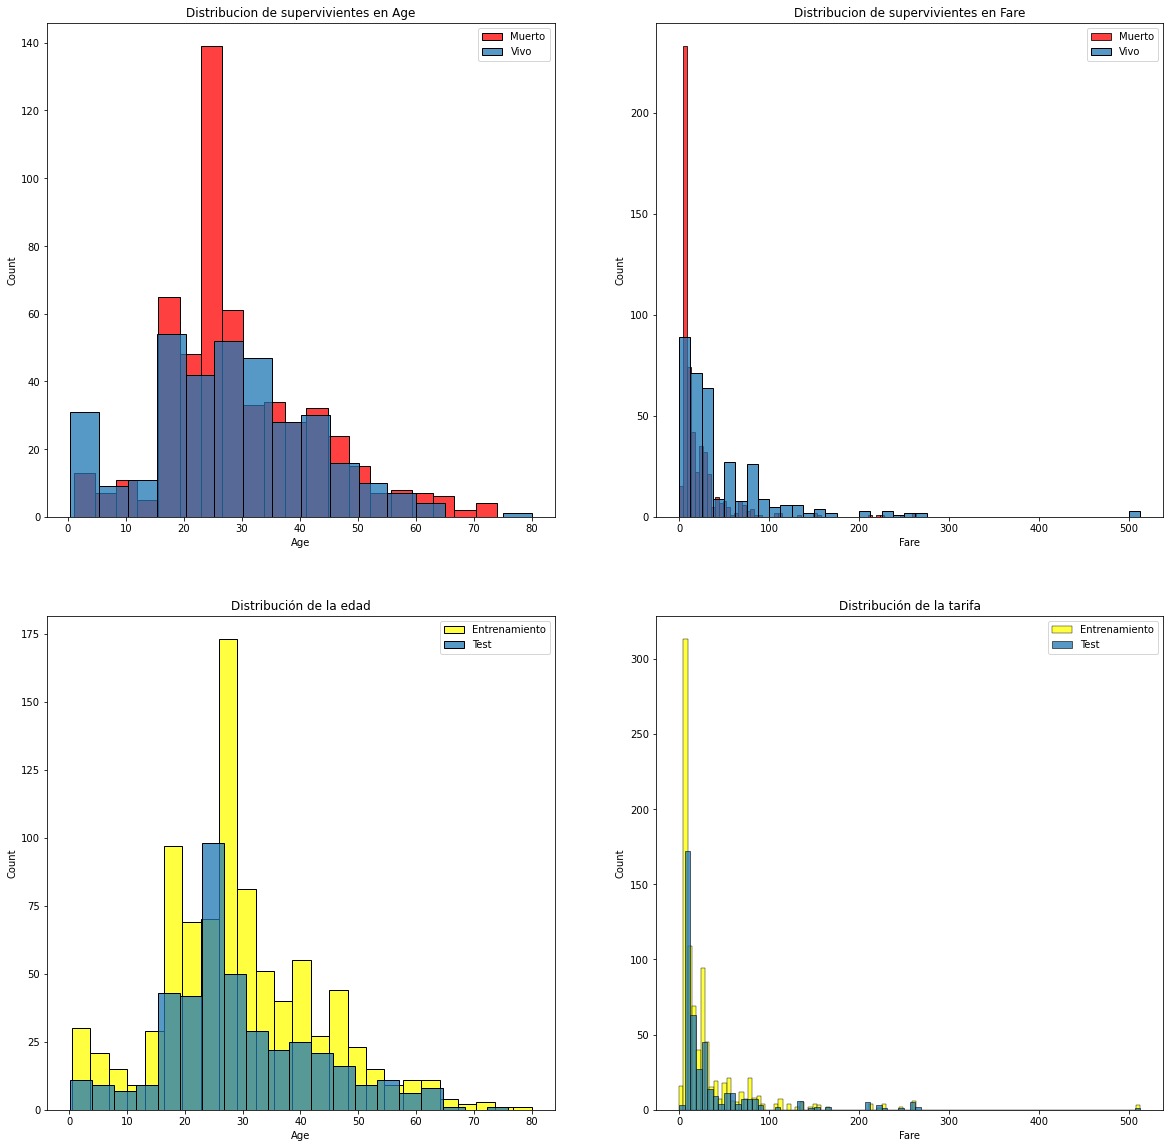

In [21]:
col_continuas = ["Age","Fare"]
surv = train.loc[train["Survived"]==1]
muerto = train.loc[train["Survived"]==0]

fig, axs = plt.subplots(ncols= 2, nrows = 2, figsize=(20,20))

for i, col in enumerate(col_continuas):
    sns.histplot(train[train["Survived"]==0][col], label = "Muerto",color='red', ax = axs[0][i])
    sns.histplot(train[train["Survived"]==1][col], label = "Vivo", ax = axs[0][i])
    
    sns.histplot(train[col], label = "Entrenamiento",color='yellow', ax = axs[1][i])
    sns.histplot(test[col], label = "Test", ax = axs[1][i])
    axs[0][i].legend()
    axs[1][i].legend()
    axs[0][i].set_title("Distribucion de supervivientes en {}".format(col))
axs[1][0].set_title("Distribución de la edad")
axs[1][1].set_title("Distribución de la tarifa")
plt.show()

Explicación de distribuciones en variables continuas, en género y clase

Para la edad podemos observar como los menores de edad tienen una proporción de más de la mitad de supervivientes, siendo asi también solamente en el intervalo de 30 a 35 años de edad. Los datos en los conjuntos de test y training vienen distribuidos de la misma manera, manteniendo así una proporción de los datos similar.

En cuanto a las tarifas, la gran mayoría de los pasajeros se encuentran por debajo de los 50, con más de 300 pasajeros en el conjunto de training con una tarifa menor a 10, por ello es ahi dónde se concentran el mayor número de supervivientes, pero con un ratio bajisimo de supervivencia debido a los más de 200 pasajeros que murieron con esa tarifa. El resto de intervalos obtiene un ratio de supervivientes mayor conforme va subiendo la tarifa del pasajero. El reparto de los datos en los conjuntos de training y test es similar en proporcion.

El género nos revela como el 74.2% de las mujeres logra sobrevivir (233 mujeres) pero tan solo un 18.9% de los hombres sobrevivieron (109 hombres), siendo un factor importante a la hora de evaluar la supervivencia del pasajero.

Y finalmente las clases de cada pasajero, dónde pertenecer a un grupo de pasajeros con una clase más privilegiada aumenta la probabilidad de supervivencia, o eso al menos parece indicar la estadistica con el porcentaje de personas que sobrevivieron por cada clase. Un 63% de supervivencia en los pasajeros de primera clase, un 47% si perteneces a la segunda clase, y tan solo un 24% en pasajeros de tercera clase. 
Cabe destacar que la cantidad de pasajeros de las clases primera y segunda estan balanceadas, con 216 de primera clase y 184 de segunda, pero que existen 491 pasajeros de tercera clase, que a pesar de ser más del doble de los pasajeros de primera clase, existen más supervivientes en el conjunto de entrenamiento de pasajeros de primera clase que de tercera.

- Ajuste caracteristicas para el modelo

In [22]:
todos['Fare'] = pd.qcut(todos['Fare'],10)

<AxesSubplot:xlabel='Fare', ylabel='count'>

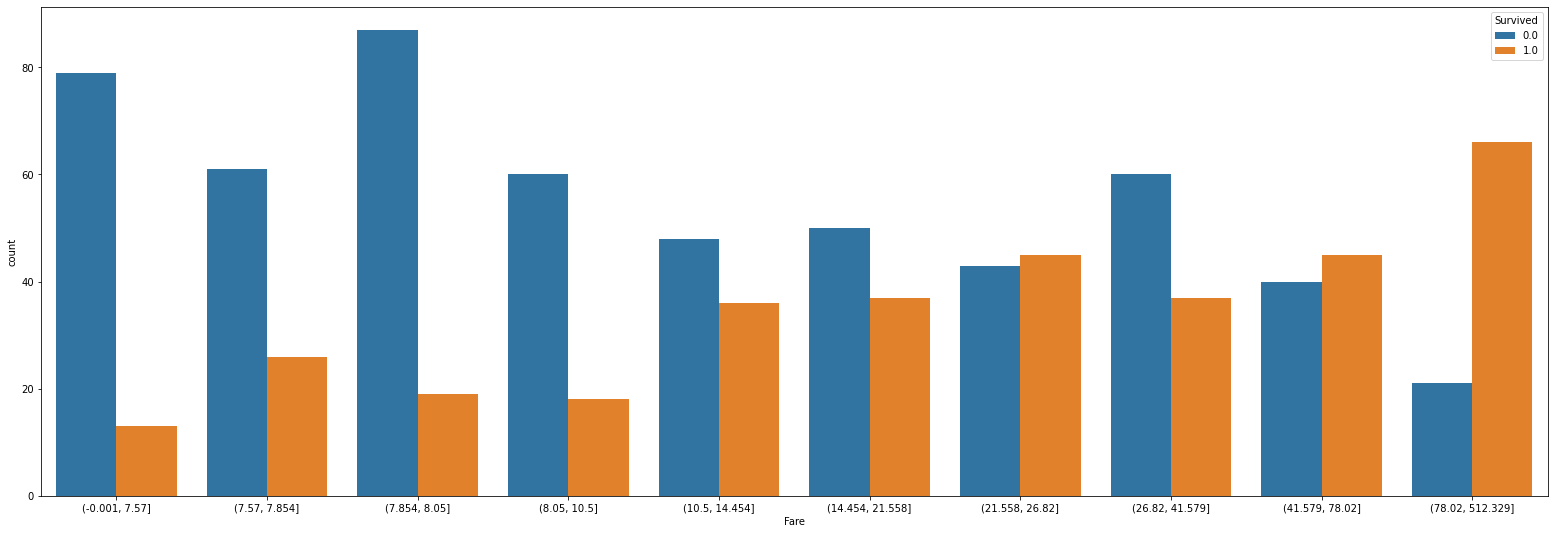

In [23]:
fig, axs = plt.subplots(figsize=(27,9))
sns.countplot(x="Fare",hue="Survived",data=todos)

In [24]:
todos['Age'] = pd.qcut(todos['Age'],9)

<AxesSubplot:xlabel='Age', ylabel='count'>

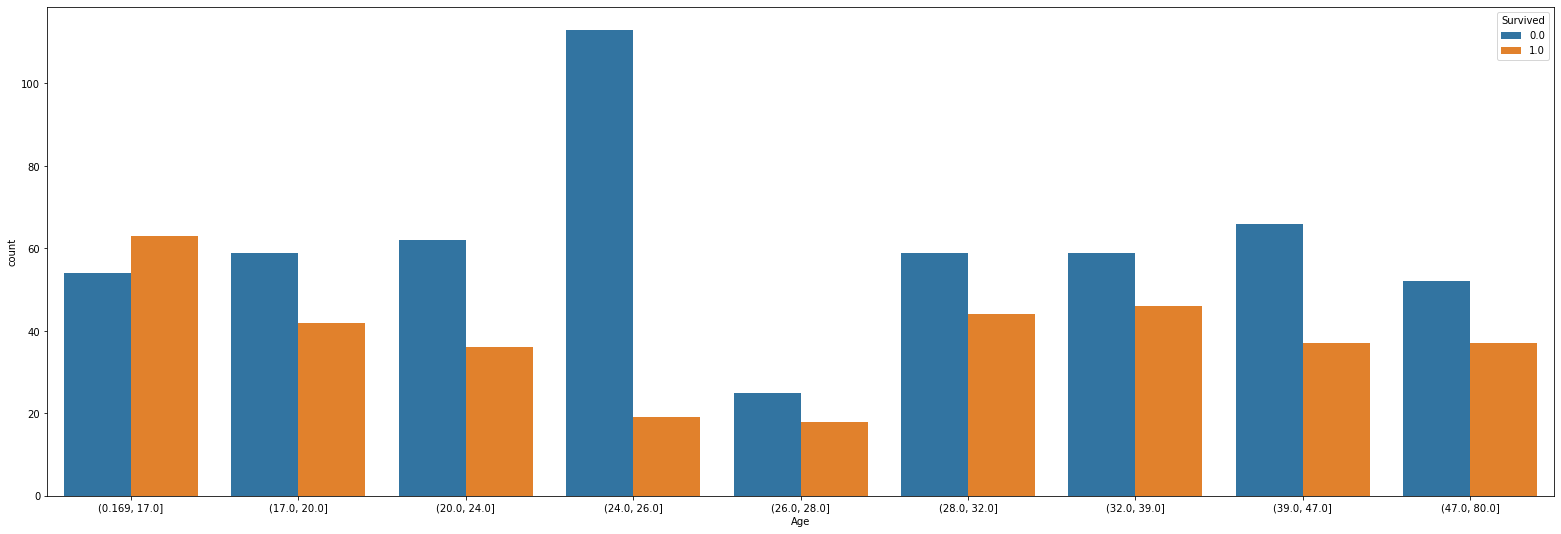

In [25]:
fig, axs = plt.subplots(figsize=(27,9))
sns.countplot(x="Age",hue="Survived",data=todos)

In [26]:
# Codificamos los intervalos en etiquetas
for col in col_continuas:
    todos[col] = LabelEncoder().fit_transform(todos[col])

Al dividir en intervalos podemos observar de mejor manera como se distribuyen los supervivientes (en naranja) a lo largo del conjunto con respecto a la edad y a la tarifa.

En la tarifa vemos que conforme más nos movemos a los intervalos de pasajeros que han pagado una tarifa mayor, por norma general, más ratio de supervivientes con respecto a fallecidos nos encontramos. 

En cuanto a la edad, observamos como el intervalo con menores de edad es el único con más supervivientes que fallecidos, teniendo el resto de intervalos una proporción similar de un número algo mayor de fallecidos que supervivientes, salvo en el intervalo de 24 a 26 años, donde hay un número de supervivientes más bajo con respecto al resto de intervalos, pero que supera las 100 personas fallecidas, donde el siguiente de los intervalos con más fallecidos tiene ligeramente más de 60 personas.

# Entrenamiento modelo

In [27]:
todos.head(2)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,male,Titulo,Emb_C,Emb_S,Emb_Q
0,2,NaN,S,0,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,1,Mr,0,1,0
1,6,C85,C,8,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,0,Mrs,1,0,0


In [28]:
todos = todos[["PassengerId","Survived","Age","male","Pclass","Fare","Parch","SibSp","Emb_C","Emb_S","Emb_Q"]]

In [29]:
todos.head(2)

,PassengerId,Survived,Age,male,Pclass,Fare,Parch,SibSp,Emb_C,Emb_S,Emb_Q
0,1,0.0,2,1,3,0,0,1,0,1,0
1,2,1.0,6,0,1,8,0,1,1,0,0


In [30]:
train = todos.loc[:890]
test = todos.loc[891:]
test.reset_index(drop=True)


,PassengerId,Survived,Age,male,Pclass,Fare,Parch,SibSp,Emb_C,Emb_S,Emb_Q
0,892,NaN,6,1,3,1,0,0,0,0,1
1,893,NaN,7,0,3,0,0,1,0,1,0
2,894,NaN,8,1,2,3,0,0,0,0,1
3,895,NaN,4,1,3,3,0,0,0,1,0
4,896,NaN,2,0,3,4,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,1,3,2,0,0,0,1,0
414,1306,NaN,6,0,1,9,0,0,1,0,0
415,1307,NaN,6,1,3,0,0,0,0,1,0
416,1308,NaN,3,1,3,2,0,0,0,1,0


In [31]:
X_train = StandardScaler().fit_transform(train[["Age","male","Pclass","Fare","Parch","SibSp","Emb_C","Emb_S","Emb_Q"]])
y_train = train["Survived"].values
X_test = StandardScaler().fit_transform(test[["Age","male","Pclass","Fare","Parch","SibSp","Emb_C","Emb_S","Emb_Q"]])
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(891, 9)
(891,)
(418, 9)


- **Regresion Logística**


In [32]:
param_grid = {'C': np.arange(1e-05, 3, 0.1)}
scoring={'Accuracy':'accuracy','AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(LogisticRegression(), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=10, refit='Accuracy')

gs.fit(X_train,y_train)
print("best_params: " + str(gs.best_estimator_))
print("best_params: " + str(gs.best_params_))
print("best_score: " + str(gs.best_score_))

best_params: LogisticRegression(C=0.10001)
best_params: {'C': 0.10001}
best_score: 0.8002247191011236


In [33]:
prediccion = pd.DataFrame()
prediccion["PassengerId"] = test["PassengerId"]
prediccion["Survived"] = gs.predict(X_test)

accuracy = gs.score(X_test,solucion["Survived"])
print(confusion_matrix(solucion["Survived"],prediccion["Survived"]))
print(accuracy)


[[255  11]
 [ 17 135]]
0.9330143540669856


- **Suport Vector Machine**

In [34]:
param_grid = {'kernel': ["linear"], 'C': [0.1, 1,10,100]}

svc = GridSearchCV(SVC(), param_grid=param_grid,refit=True,verbose=2,cv=10)

svc.fit(X_train,y_train)
print("best_params: " + str(svc.best_estimator_))
print("best_params: " + str(svc.best_params_))
print("best_score: " + str(svc.best_score_))

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END .................................C=1, kernel=linear; total time=   0.0s
[CV] END .................................C=1, k

In [35]:
prediccion = pd.DataFrame()
prediccion["PassengerId"] = test["PassengerId"]
prediccion["Survived"] = svc.predict(X_test)
print(prediccion)


accuracy = svc.score(X_test,solucion["Survived"])
print(confusion_matrix(solucion["Survived"],prediccion["Survived"]))
print(accuracy)

      PassengerId  Survived
891           892       0.0
892           893       1.0
893           894       0.0
894           895       0.0
895           896       1.0
...           ...       ...
1304         1305       0.0
1305         1306       1.0
1306         1307       0.0
1307         1308       0.0
1308         1309       0.0

[418 rows x 2 columns]
[[266   0]
 [  0 152]]
1.0


- **Random Forrest**

In [36]:
param_grid = {'n_estimators': [100,200,400], 'max_depth': [3, 5,6,7],'criterion': ['gini','entropy']}

r_for = GridSearchCV(RandomForestClassifier(), param_grid=param_grid,verbose=2,cv=5)

r_for.fit(X_train,y_train)
print("best_params: " + str(r_for.best_estimator_))
print("best_params: " + str(r_for.best_params_))
print("best_score: " + str(r_for.best_score_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ......criterion=gini, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ......criterion=gini, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ......criterion=gini, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ......criterion=gini, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ......criterion=gini, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ......criterion=gini, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END ......criterion=gini, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END ......criterion=gini, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END ......criterion=gini, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END ......criterion=gini, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END ......criterion=gini, max_depth=3, n_estimators=400; total time=   0.3s
[CV] END ......criterion=gini, max_depth=3, n_e

In [37]:
prediccion = pd.DataFrame()
prediccion["PassengerId"] = test["PassengerId"]
prediccion["Survived"] = r_for.predict(X_test)
print(prediccion)


accuracy = r_for.score(X_test,solucion["Survived"])
print(confusion_matrix(solucion["Survived"],prediccion["Survived"]))
print(accuracy)

      PassengerId  Survived
891           892       0.0
892           893       0.0
893           894       0.0
894           895       0.0
895           896       1.0
...           ...       ...
1304         1305       0.0
1305         1306       1.0
1306         1307       0.0
1307         1308       0.0
1308         1309       1.0

[418 rows x 2 columns]
[[251  15]
 [ 34 118]]
0.8827751196172249


- **Decision Tree**

In [38]:
param_grid = {'ccp_alpha': [0.001,0.01,0.1], 'max_depth': [5,6,7,8],'criterion': ['gini','entropy']}

d_tree = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid,verbose=2,cv=5)

d_tree.fit(X_train,y_train)
print("best_params: " + str(d_tree.best_estimator_))
print("best_params: " + str(d_tree.best_params_))
print("best_score: " + str(d_tree.best_score_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END .......ccp_alpha=0.001, criterion=gini, max_depth=5; total time=   0.0s
[CV] END .......ccp_alpha=0.001, criterion=gini, max_depth=5; total time=   0.0s
[CV] END .......ccp_alpha=0.001, criterion=gini, max_depth=5; total time=   0.0s
[CV] END .......ccp_alpha=0.001, criterion=gini, max_depth=5; total time=   0.0s
[CV] END .......ccp_alpha=0.001, criterion=gini, max_depth=5; total time=   0.0s
[CV] END .......ccp_alpha=0.001, criterion=gini, max_depth=6; total time=   0.0s
[CV] END .......ccp_alpha=0.001, criterion=gini, max_depth=6; total time=   0.0s
[CV] END .......ccp_alpha=0.001, criterion=gini, max_depth=6; total time=   0.0s
[CV] END .......ccp_alpha=0.001, criterion=gini, max_depth=6; total time=   0.0s
[CV] END .......ccp_alpha=0.001, criterion=gini, max_depth=6; total time=   0.0s
[CV] END .......ccp_alpha=0.001, criterion=gini, max_depth=7; total time=   0.0s
[CV] END .......ccp_alpha=0.001, criterion=gini

In [39]:
prediccion = pd.DataFrame()
prediccion["PassengerId"] = test["PassengerId"]
prediccion["Survived"] = d_tree.predict(X_test)
print(prediccion)


accuracy = d_tree.score(X_test,solucion["Survived"])
print(confusion_matrix(solucion["Survived"],prediccion["Survived"]))
print(accuracy)

      PassengerId  Survived
891           892       0.0
892           893       1.0
893           894       0.0
894           895       0.0
895           896       1.0
...           ...       ...
1304         1305       0.0
1305         1306       1.0
1306         1307       0.0
1307         1308       0.0
1308         1309       1.0

[418 rows x 2 columns]
[[253  13]
 [  4 148]]
0.9593301435406698


# Conclusiones

Se han probado 4 modelos distintos para la predicción del conjunto test: Regresión Logística, Vectores de soporte, Árboles aleatorios y Árboles de decisión.

Con todos los modelos se ha realizado una validación cruzada con la funcion GridSearchCV, que nos sirve además para ajustar mejor los hiperparámetros del modelo a nuestro problema, los resultados con respecto a los conjuntos de validación de los 4 modelos rondan entre un 78% y 82% de accuracy, pero curiosamente los mejores resultados en la precisión del conjunto de test se observan en los modelos con menor precisión (Support Vector Machine y Decision Tree), alcanzando un 100% de precisión en test para SVC y un 95.9% de precision para DecisionTreeClassifier.